Universidad Galileo  
Maestría en Data Science  
Statistical Learning I
Sección U  


   # **Proyecto final: Clasificación de supervivencia en el Titanic**


<p style="text-align: right;">
Henry Giovanni<br/>
Barrientos García<br/>
21001538<br/>
Guatemala, 02 de julio de 2022<br/>
</p>

# Clasificación de Supervivencia en el naufragio del Titanic

<img src="images/titanic.jpg" alt="Titanic" width="50%" height="50%"/>

El proyecto consiste en hacer clasificación binaria para determinar si una persona sobrevive (y=1) o no (y=0) del hundimiento del Titanic. En este proyecto se busca crear un modelo con un nivel de exactitud de al menos el **80%** (aunque es posible crear modelos mejores que esto).

El proyecto está dividido en 2 partes:
1. Entrenamiento, selección y validación.
2. Inferencia, predicción y despliegue de modelos

# Parte 1: Entrenamiento, selección y validación

### Carga de librerías

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import datetime
import scipy
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder, normalize, scale
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from joblib import dump

%load_ext tensorboard
tf.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


AttributeError: module 'tensorflow._api.v1.compat.v1.compat' has no attribute 'v1'

### Análisis exploratorio de datos

In [2]:
sv_titanic = pd.read_csv("data/data_titanic_proyecto.csv")

In [3]:
sv_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PassengerId         891 non-null    int64  
 1   Name                891 non-null    object 
 2   Age                 714 non-null    float64
 3   SibSp               891 non-null    int64  
 4   Parch               891 non-null    int64  
 5   Ticket              891 non-null    object 
 6   Fare                891 non-null    float64
 7   Cabin               204 non-null    object 
 8   Embarked            889 non-null    object 
 9   passenger_class     891 non-null    object 
 10  passenger_sex       891 non-null    object 
 11  passenger_survived  891 non-null    object 
dtypes: float64(2), int64(3), object(7)
memory usage: 83.7+ KB


Observamos que el total de personas/registros de sobrevivientes del titanic son 891, distribuidos en 12 columnas. Las columnas son de distintos tipos y vemos que algunas presentan datos *nulos*.

In [4]:
# Análisis estadístico rápido de los datos
sv_titanic.describe()

,PassengerId,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,29.699118,0.523008,0.381594,32.204208
std,257.353842,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,38.000000,1.000000,0.000000,31.000000
max,891.000000,80.000000,8.000000,6.000000,512.329200


Al analizar la distribución de las variables numéricas y vemos que las escalas numéricas son distintas y que existe mucha diferencia entre las distribuciones de estas.

In [5]:
# Previsualización de algunos datos
sv_titanic.head()

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
0,1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Lower,M,N
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Upper,F,Y
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Lower,F,Y
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Upper,F,Y
4,5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Lower,M,N


Al validar algunos de los datos del dataset vemos que algunas columnas no son necesarias para realizar el análisis, por lo cual estas las eliminaremos del conjunto de datos. Las columnas a eliminar son: **PassengerId, Name, Ticket, Cabin**.

In [6]:
# Validamos el porcentaje de valoes null para cada columna
#print("% de Null en cada columna\n", round(sv_titanic.isnull().sum() / len(sv_titanic.index) * 100, 2))
print("Columna\t\t\t% de Null\n")
print(round(sv_titanic.isnull().sum() / len(sv_titanic.index) * 100, 2))


Columna			% de Null

PassengerId            0.00
Name                   0.00
Age                   19.87
SibSp                  0.00
Parch                  0.00
Ticket                 0.00
Fare                   0.00
Cabin                 77.10
Embarked               0.22
passenger_class        0.00
passenger_sex          0.00
passenger_survived     0.00
dtype: float64


### Feature Engineering

Vemos que la columna **Age** (edad) del dataset tiene una cantidad considerable de valores null con casi el 20% de su contenido, por lo cual vemos necesario realizar featuring engineering a esta columna, por lo que aplicaremos la técnica de imputación **"median"** a las edades que tenga un valor null.

In [7]:
medianaAge = sv_titanic['Age'].median()
sv_titanic['Age'] = sv_titanic['Age'].fillna(medianaAge)

Para la columnas **passenger_sex y passenger_survived** se reemplazan sus valores tipo cadena por valores numéricos de la forma siguiente:
1. passenger_sex:      F = 0 y M = 1
2. passenger_survived: N = 0 y Y = 1

In [8]:
sv_titanic['passenger_sex'] = sv_titanic['passenger_sex'].replace('F', 0)
sv_titanic['passenger_sex'] = sv_titanic['passenger_sex'].replace('M', 1)
sv_titanic['passenger_survived'] = sv_titanic['passenger_survived'].replace('N', 0)
sv_titanic['passenger_survived'] = sv_titanic['passenger_survived'].replace('Y', 1)

Las columnas **passenger_class y Embarked** son candidatas a aplicarles One Hot Encoding, lo vemos a continuación:

In [9]:
def get_classes(columnName):
    classes = np.array(sv_titanic[columnName]).reshape(-1,1)
    clases = OneHotEncoder(categories='auto')
    clases.fit(classes)
    classes = clases.transform(classes).toarray()
    return classes

**passenger_class**

In [10]:
ohe_classes = get_classes("passenger_class")
sv_titanic['LClass'], sv_titanic['MClass'], sv_titanic['UClass'] = [ohe_classes.T[0], ohe_classes.T[1], ohe_classes.T[2]]

**Embarked**

In [11]:
ohe_classes = get_classes("Embarked")
sv_titanic['EmbarkedC'], sv_titanic['EmbarkedQ'], sv_titanic['EmbarkedS'] = [ohe_classes.T[0], ohe_classes.T[1], ohe_classes.T[2]]

#### Visualización de variables

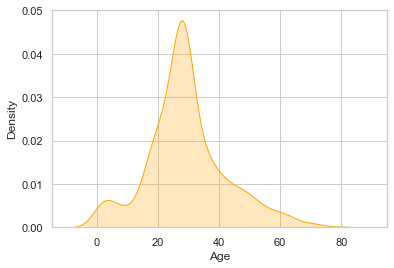

In [12]:
# Age
sns.set_theme(style = "whitegrid")
sns.kdeplot(sv_titanic["Age"], shade = True, color = "orange")
plt.show()

La mayor parte de las personas que abordaronel Titanic tenían aproximadamente 30 años, la persona con más pequeña tenía 0.5 años (6 meses) y la de mayor edad tenía 80 años.

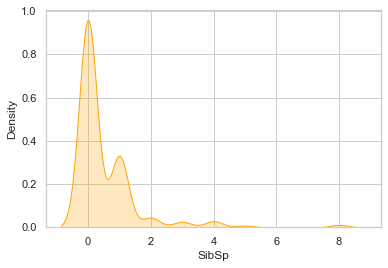

In [13]:
# SibSp
sns.kdeplot(sv_titanic["SibSp"], shade = True, color = "orange")
plt.show()

La gran mayoría de pasajeros no viajaban acompañados o con sus parientes. Hubieron algunas personas que iban acompañadas con 4 y la persona que llevaba mas acompañantes iba con 8 personas.

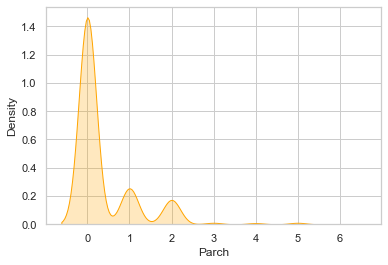

In [14]:
# Parch
sns.kdeplot(sv_titanic["Parch"], shade = True, color = "orange")
plt.show()

La mayoría de pasajeros no viajaban acompañados de sus hijos o padres. El pasajero con más hijos o padres en el Titanic iba acompañada por 6 personas.

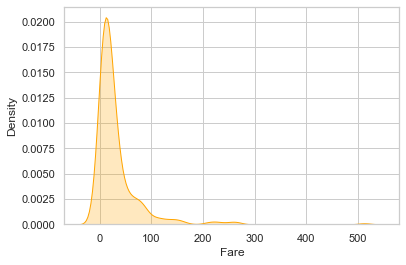

In [15]:
# Fare
sns.kdeplot(sv_titanic["Fare"], shade = True, color = "orange")
plt.show()

Según los datos se observa que aproximadamente 75% de los pasajeros pagó 31 como precio de boleto. Así mismo algunos no pagaron tarifa y unos pocos pagaron una tarifa alta.

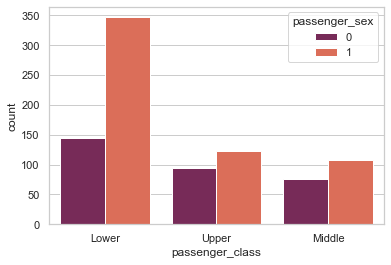

In [16]:
# Cantidad de pasajeros por clase categorizados por sexo, recordemos que passenger_sex: F = 0 y M = 1
sns.countplot(x = 'passenger_class', hue = 'passenger_sex', data = sv_titanic, palette = 'rocket')
plt.show()

No importando el nivel social, la cantidad de hombres es mayor respecto de la cantidad de mujeres.

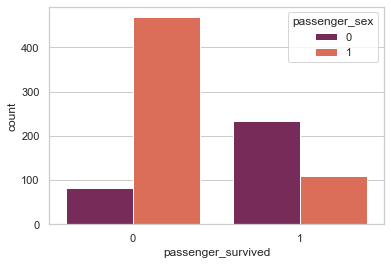

In [17]:
# Pasajeros sobrevivientes categorizados por sexo, recordemos que passenger_sex: F = 0 y M = 1
sns.countplot(x = 'passenger_survived', hue = 'passenger_sex', data = sv_titanic, palette = 'rocket')
plt.show()

De los datos se observa que hubo una mayor cantidad de sobrevivients mujeres, y en complemento a esto la mayor cantidad de pasajeros que fallecieron fueron hombres.

#### Normalización de variables
Por otro lado vemos que los valores de las variables numéricas están en distintas escalas numéricas, por ello se procede a normalizar algunas variables.

In [18]:
sv_titanic[['Age', 'SibSp', 'Parch', 'Fare']] = normalize(sv_titanic[['Age', 'SibSp', 'Parch', 'Fare']])

In [19]:
# Columnas que no se usaran para el análisis
sv_titanic = sv_titanic.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked', 'passenger_class'], axis = 1)
sv_titanic

,Age,SibSp,Parch,Fare,passenger_sex,passenger_survived,LClass,MClass,UClass,EmbarkedC,EmbarkedQ,EmbarkedS
0,0.948873,0.043131,0.000000,0.312697,1,0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.470381,0.012378,0.000000,0.882377,0,1,0.0,0.0,1.0,1.0,0.0,0.0
2,0.956551,0.000000,0.000000,0.291564,0,1,1.0,0.0,0.0,0.0,0.0,1.0
3,0.550270,0.015722,0.000000,0.834839,0,1,0.0,0.0,1.0,0.0,0.0,1.0
4,0.974555,0.000000,0.000000,0.224148,1,0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.901002,0.000000,0.000000,0.433816,1,0,0.0,1.0,0.0,0.0,0.0,1.0
887,0.535052,0.000000,0.000000,0.844819,0,1,0.0,0.0,1.0,0.0,0.0,1.0
888,0.765215,0.027329,0.054658,0.640868,0,0,1.0,0.0,0.0,0.0,0.0,1.0
889,0.654931,0.000000,0.000000,0.755689,1,1,0.0,0.0,1.0,1.0,0.0,0.0


### Split de datos

In [20]:
y = sv_titanic['passenger_survived']
x = sv_titanic.drop(columns=['passenger_survived'])

In [21]:
# Train y Test
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.20, random_state=1987)

In [22]:
# Validation
xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size=0.20, random_state=1987)

In [23]:
print('% Train =', round((len(xTrain.index) / len(y.index)) * 100, 2 ))
print('% Validation =', round((len(xVal.index) / len(y.index)) * 100, 2 ))
print('% Test =', round((len(xTest.index) / len(y.index)) * 100, 2 ))

% Train = 63.86
% Validation = 16.05
% Test = 20.09


### Construcción de modelos de entrenamiento

#### Árbol de decisión

Para el árbol de decisión se tomó como parámetro de configuración **max_depth**

In [24]:
def train_modelDecisionTreeClassifier(xTrain, yTrain, xVal, yVal, max_depth = None):
    model = DecisionTreeClassifier(max_depth = max_depth)
    model.fit(xTrain, yTrain)
    trainAccuracy = model.score(xTrain, yTrain)
    valAccuracy = model.score(xVal, yVal)
    return model, trainAccuracy,valAccuracy

##### Experimento 1

In [25]:
model, trainAccuracy,valAccuracy = train_modelDecisionTreeClassifier(xTrain, yTrain, xVal, yVal)

print('---------- max_depth=None----------')
print('Train Accuracy = ', round(trainAccuracy, 2))
print('Validation Accuracy = ', round(valAccuracy, 2))

---------- max_depth=None----------
Train Accuracy =  0.98
Validation Accuracy =  0.71


##### Experimento 2 - 9

In [26]:
for i in range (1,11):
    model, trainAccuracy,valAccuracy = train_modelDecisionTreeClassifier(xTrain, yTrain, xVal, yVal, max_depth=i)
    print('---------- max_depth =',i ,'----------')
    print('Train Accuracy = ', round(trainAccuracy, 2))
    print('Validation Accuracy = ', round(valAccuracy, 2))

---------- max_depth = 1 ----------
Train Accuracy =  0.77
Validation Accuracy =  0.77
---------- max_depth = 2 ----------
Train Accuracy =  0.78
Validation Accuracy =  0.78
---------- max_depth = 3 ----------
Train Accuracy =  0.81
Validation Accuracy =  0.83
---------- max_depth = 4 ----------
Train Accuracy =  0.82
Validation Accuracy =  0.78
---------- max_depth = 5 ----------
Train Accuracy =  0.85
Validation Accuracy =  0.79
---------- max_depth = 6 ----------
Train Accuracy =  0.86
Validation Accuracy =  0.78
---------- max_depth = 7 ----------
Train Accuracy =  0.88
Validation Accuracy =  0.76
---------- max_depth = 8 ----------
Train Accuracy =  0.91
Validation Accuracy =  0.73
---------- max_depth = 9 ----------
Train Accuracy =  0.92
Validation Accuracy =  0.73
---------- max_depth = 10 ----------
Train Accuracy =  0.93
Validation Accuracy =  0.72


Despues de los pasos de experimentación determinamos que el mejor modelo se encuentra al utilizar el parámetro max_depth = 3

In [27]:
# Seleccionando el mejor modelDecisionTreeClassifier
bestModelDecisionTreeClassifier, trainAccuracyTree,valAccuracyTree = train_modelDecisionTreeClassifier(xTrain,
                                                                                                       yTrain,
                                                                                                       xVal,
                                                                                                       yVal,
                                                                                                       max_depth=3)

In [28]:
# Almacenar modelo
dump(bestModelDecisionTreeClassifier, "models/modelDecisionTreeClassifier(max_depth=3).joblib")

['models/modelDecisionTreeClassifier(max_depth=3).joblib']

#### SVM

Para el modelo SVM se tomarán en cuenta los parámetros de configuración **C y Kernel**.

In [29]:
def train_modelSVM(xTrain, yTrain, xVal, yVal, C = 1.0, kernel = 'rbf'):
    model = svm.SVC(C = C, kernel = kernel)
    model.fit(xTrain, yTrain)
    trainAccuracy = model.score(xTrain, yTrain)
    valAccuracy = model.score(xVal, yVal)
    return model, trainAccuracy,valAccuracy

##### Experimento 1

In [30]:
for i in range(1, 5):
    model, trainAccuracy,valAccuracy = train_modelSVM(xTrain, yTrain, xVal, yVal, C= i)
    print('---------- C=',i,'kernel=rbf----------')
    print('Train Accuracy = ', round(trainAccuracy, 2))
    print('Validation Accuracy = ', round(valAccuracy, 2))

---------- C= 1 kernel=rbf----------
Train Accuracy =  0.8
Validation Accuracy =  0.83
---------- C= 2 kernel=rbf----------
Train Accuracy =  0.8
Validation Accuracy =  0.83
---------- C= 3 kernel=rbf----------
Train Accuracy =  0.81
Validation Accuracy =  0.81
---------- C= 4 kernel=rbf----------
Train Accuracy =  0.81
Validation Accuracy =  0.82


##### Experimento 2

In [31]:
for i in range(1, 5):
    model, trainAccuracy,valAccuracy = train_modelSVM(xTrain, yTrain, xVal, yVal, C= i, kernel = 'linear')
    print('---------- C=',i,'kernel=linear----------')
    print('Train Accuracy = ', round(trainAccuracy, 2))
    print('Validation Accuracy = ', round(valAccuracy, 2))

---------- C= 1 kernel=linear----------
Train Accuracy =  0.77
Validation Accuracy =  0.77
---------- C= 2 kernel=linear----------
Train Accuracy =  0.77
Validation Accuracy =  0.77
---------- C= 3 kernel=linear----------
Train Accuracy =  0.77
Validation Accuracy =  0.77
---------- C= 4 kernel=linear----------
Train Accuracy =  0.77
Validation Accuracy =  0.77


In [32]:
for i in range(1, 5):
    model, trainAccuracy,valAccuracy = train_modelSVM(xTrain, yTrain, xVal, yVal, C= i, kernel = 'poly')
    print('---------- C=',i,'kernel=poly----------')
    print('Train Accuracy = ', round(trainAccuracy, 2))
    print('Validation Accuracy = ', round(valAccuracy, 2))

---------- C= 1 kernel=poly----------
Train Accuracy =  0.81
Validation Accuracy =  0.81
---------- C= 2 kernel=poly----------
Train Accuracy =  0.81
Validation Accuracy =  0.8
---------- C= 3 kernel=poly----------
Train Accuracy =  0.81
Validation Accuracy =  0.82
---------- C= 4 kernel=poly----------
Train Accuracy =  0.81
Validation Accuracy =  0.82


In [33]:
for i in range(1, 5):
    model, trainAccuracy,valAccuracy = train_modelSVM(xTrain, yTrain, xVal, yVal, C= i, kernel = 'sigmoid')
    print('---------- C=',i,'kernel=sigmoid----------')
    print('Train Accuracy = ', round(trainAccuracy, 2))
    print('Validation Accuracy = ', round(valAccuracy, 2))

---------- C= 1 kernel=sigmoid----------
Train Accuracy =  0.68
Validation Accuracy =  0.74
---------- C= 2 kernel=sigmoid----------
Train Accuracy =  0.67
Validation Accuracy =  0.74
---------- C= 3 kernel=sigmoid----------
Train Accuracy =  0.6
Validation Accuracy =  0.71
---------- C= 4 kernel=sigmoid----------
Train Accuracy =  0.67
Validation Accuracy =  0.73


Determinamos que el mejor modelo es el del parámetro C=2 y kernel=rbf

In [34]:
bestModelSVM, trainAccuracySVM,valAccuracySVM = train_modelSVM(xTrain,
                                                               yTrain,
                                                               xVal,
                                                               yVal,
                                                               C=2,
                                                               kernel='rbf')

In [35]:
dump(bestModelSVM, "models/modelSVM(C=2,kernel=rbf).joblib")

['models/modelSVM(C=2,kernel=rbf).joblib']

#### Naive Bayes

Para este algoritmo se implementan todos los pasos, según el siguiente código

In [36]:
def train_NaiveBayes(xTrain):
    
    # Separamos la columnas en las que el resultado es 0 y 1 (no sobrevivió o sobrevivió)
    xTrain0 = xTrain[yTrain == 0]
    xTrain1 = xTrain[yTrain == 1]
    # Estas son las medidas que nos serviran para normalizar cada columna y calcular su valor correspondiente
    xTrainMean0 = np.mean(xTrain0)
    xTrainStd0 = np.std(xTrain0)
    xTrainMedidas0 = np.stack((xTrainMean0, xTrainStd0), axis=0)
    xTrainMedidas0 = xTrainMedidas0.T


    xTrainMean1 = np.mean(xTrain1)
    xTrainStd1 = np.std(xTrain1)
    xTrainMedidas1 = np.stack((xTrainMean1, xTrainStd1), axis=0)
    xTrainMedidas1 = xTrainMedidas1.T

    # Training
    temp0 = []
    temp1 = []

    for i in range(0, xTrainMedidas0.shape[0]):
        # Se calculan las probabilidades con base a las medidas mean y std para cada columna tanto para valores 0 y 1
        valor0 = stats.norm(xTrainMedidas0[i][0], xTrainMedidas0[i][1]).cdf(xTrain.iloc[:, [i]])
        valor1 = stats.norm (xTrainMedidas1[i][0], xTrainMedidas0[i][1]).cdf(xTrain.iloc[:, [i]])
        temp0.append(valor0)
        temp1.append(valor1)
    
    xTrainVal0 = np.array(temp0).T.squeeze()
    xTrainVal1 = np.array(temp1).T.squeeze()
    
    # Cálculo de la probabilidad para los sobrevivientes y no sobrevivientes
    Probabilidad0 = 1-np.mean(yTrain) #No sobrevivientes
    Probabilidad1 = np.mean(yTrain) #Sobrevivientes
    
    # Agregando las probabilidades como columna extra
    x0 = np.concatenate((xTrainVal0, np.full_like(xTrainVal0[:,0],Probabilidad0).reshape(-1,1)), axis = 1)
    x1 = np.concatenate((xTrainVal1, np.full_like(xTrainVal1[:,0],Probabilidad1).reshape(-1,1)), axis = 1)
    
    # Calculando valores para y
    y0 = np.prod(x0,axis=1).reshape(-1,1)
    y1 = np.prod(x1,axis=1).reshape(-1,1)
    
    # Unificando valores
    y01 = np.concatenate((y0,y1), axis=1)
    
    # Calculando predicciones
    predictions = np.argmax(y01, axis = 1)
    
    # Calculando Accuracy
    trainAccuracy = np.mean(predictions == yTrain)
    
    # ------Validation---------#
    # Cálculo de los valores correspondientes (normalización)
    temp0Val = []
    temp1Val = []

    for i in range(0, xTrainMedidas0.shape[0]):
        # Se calculan las probabilidades con base a las medidas mean y std para cada columna tanto para valores 0 y 1
        valor0Val = stats.norm(xTrainMedidas0[i][0], xTrainMedidas0[i][1]).cdf(xVal.iloc[:, [i]])
        valor1Val = stats.norm (xTrainMedidas1[i][0], xTrainMedidas0[i][1]).cdf(xVal.iloc[:, [i]])
        temp0Val.append(valor0Val)
        temp1Val.append(valor1Val)
    
    xValVal0 = np.array(temp0Val).T.squeeze()
    xValVal1 = np.array(temp1Val).T.squeeze()
    
    # Agregando las probabilidades como columna extra
    x0Val = np.concatenate((xValVal0, np.full_like(xValVal0[:,0],Probabilidad0).reshape(-1,1)), axis = 1)
    x1Val = np.concatenate((xValVal1, np.full_like(xValVal1[:,0],Probabilidad1).reshape(-1,1)), axis = 1)
    
    # Calculando valores para y
    y0Val = np.prod(x0Val,axis=1).reshape(-1,1)
    y1Val = np.prod(x1Val,axis=1).reshape(-1,1)
    
    # Unificando valores
    y01Val = np.concatenate((y0Val,y1Val), axis=1)
    
    # Calculando predicciones
    prediccionesVal = np.argmax(y01Val, axis = 1)
    
    # Calculando Accuracy
    valAccuracy = np.mean(prediccionesVal == yVal)
    
    model = {"nb0": xTrainMedidas0, "nb1":xTrainMedidas1}
    
    return model, trainAccuracy, valAccuracy

##### Experimento 1

In [37]:
model,trainAccuracy,valAccuracy = train_NaiveBayes(xTrain)
print('---------- Todas las columnas----------')
print('Train Accuracy = ', round(trainAccuracy, 2))
print('Validation Accuracy = ', round(valAccuracy, 2))

---------- Todas las columnas----------
Train Accuracy =  0.74
Validation Accuracy =  0.75


In [38]:
for col in xTrain.columns:
    model,trainAccuracy,valAccuracy = train_NaiveBayes(xTrain.drop(columns = col))
    print('------ Sin',col,'-------')
    print('Train Accuracy = ', round(trainAccuracy, 2))
    print('Validation Accuracy = ', round(valAccuracy, 2))

------ Sin Age -------
Train Accuracy =  0.77
Validation Accuracy =  0.57
------ Sin SibSp -------
Train Accuracy =  0.74
Validation Accuracy =  0.68
------ Sin Parch -------
Train Accuracy =  0.74
Validation Accuracy =  0.71
------ Sin Fare -------
Train Accuracy =  0.71
Validation Accuracy =  0.43
------ Sin passenger_sex -------
Train Accuracy =  0.7
Validation Accuracy =  0.71
------ Sin LClass -------
Train Accuracy =  0.75
Validation Accuracy =  0.73
------ Sin MClass -------
Train Accuracy =  0.75
Validation Accuracy =  0.72
------ Sin UClass -------
Train Accuracy =  0.72
Validation Accuracy =  0.71
------ Sin EmbarkedC -------
Train Accuracy =  0.74
Validation Accuracy =  0.73
------ Sin EmbarkedQ -------
Train Accuracy =  0.75
Validation Accuracy =  0.71
------ Sin EmbarkedS -------
Train Accuracy =  0.74
Validation Accuracy =  0.76


Luego de la experimentación encontramos que el mejor modelo es aquel en el que se excluye la variable **EmbarkedS**

In [39]:
bestModelNaiveBayes, trainAccuracyNaiveBayes,valAccuracyNaiveBayes = train_NaiveBayes(xTrain.drop(columns =['EmbarkedS']))

In [40]:
dump(bestModelNaiveBayes, "models/modelNaiveBayes(sinVariable=EmbarkedS).joblib")

['models/modelNaiveBayes(sinVariable=EmbarkedS).joblib']

#### Regresión Logística

Para este algoritmo se usó como base el algorito del laboratorio anterior.

In [41]:
# Convertir arreglos en formato tensorflow
yTrainTF = np.array(yTrain).reshape(-1,1)
yValTF = np.array(yVal).reshape(-1,1)

xTrainTF = np.insert(np.array(xTrain),0, np.ones(len(xTrain)), axis = 1)
xValTF = np.insert(np.array(xVal),0, np.ones(len(xVal)), axis = 1)

In [42]:
class MRL:
    def __init__(self, x, parameters, regularizacion):
        self.parametros = tf.get_variable("parametros", dtype = tf.float32,
                                          shape = [1, x.shape[1]],
                                          initializer = tf.zeros_initializer())
        self.parameters = tf.constant(parameters, dtype = tf.float32)
        self.regularizacion = regularizacion
                                            
    # Cálculo de predicciones
    def getPrediction(self, x):
        sigmoid = tf.nn.sigmoid(self.logits(x))
        return tf.round(sigmoid)
    
    # Cálculo de accuracy
    def getAccuracy(self, predictions, labels):
        a = tf.equal(predictions, labels)
        a = tf.cast(a, tf.int32)
        a = tf.divide(tf.reduce_sum(a), tf.shape(labels)[0])
        return a
    
    # Cálculo de logits
    def logits(self, x):
        return tf.matmul(x, tf.transpose(self.parametros))
    
    # Cálculo función de costo
    def loss(self, x, y):
        cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y, logits = self.logits(x)))
        if self.regularizacion == 'lasso':
            error = tf.add(cross_entropy,tf.multiply(self.parameters, tf.reduce_sum(tf.abs(self.parametros))))
        if self.regularizacion == 'ridge':
            error = tf.add(cross_entropy, tf.multiply(self.parameters, tf.sqrt(tf.reduce_sum(tf.square(self.parametros)))))
        return error
    
    # Cálculo de parámetro por medio de gradient descent
    def gradient_descent(self, xtrain, ytrain, xtest, ytest, lr):
        
        # Para Error
        with tf.name_scope("error"):
            train_error = self.loss(xtrain, ytrain)
            train_error_summary = tf.summary.scalar("TrainError", train_error)
            test_error = self.loss(xtest, ytest)
            test_error_summary = tf.summary.scalar("ValError", test_error)
            
        # Para Accuracy
        with tf.name_scope("accuracy"):
            train_accuracy = self.getAccuracy(self.getPrediction(xtrain), ytrain)
            train_accuracy_summary = tf.summary.scalar("TrainAccuracy", train_accuracy)
            test_accuracy = self.getAccuracy(self.getPrediction(xtest), ytest)
            test_accuracy_summary = tf.summary.scalar("ValtAccuracy", test_accuracy)
        
        # Cálculo de nuevos parámetros con Gradient Descent
        gradiente = tf.gradients(train_error, [self.parametros])
        new_parametros = tf.assign(self.parametros, self.parametros - lr * gradiente[0])
        return new_parametros, train_error, test_error, train_accuracy, test_accuracy, train_error_summary, test_error_summary, train_accuracy_summary, test_accuracy_summary

In [43]:
def train_LogisticRegression(lr, epochs, printl, xtrain, xtest, labels_train, labels_test, batchSize, parameters, regularizacion):
    
    # Tensorboard
    directory = './experiments/LogRegression'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S") +"_lr="+str(lr)+ "_epochs="+str(epochs) + "_batchSize=" \
    + str(batchSize) + '_parameters=' + str(parameters) + "_regularizacion=" + regularizacion

    # Definición del grafo
    graph = tf.Graph()
    with graph.as_default():
        
         # Creación de los tensores input
        with tf.name_scope("train_tensors"):
            tensor_x_train = tf.placeholder(tf.float32, [None,xtrain.shape[1]], "tensor_x_train")
            tensor_labels_train = tf.placeholder(tf.float32, [None,labels_train.shape[1]], "tensor_labels_train")
        with tf.name_scope("test_tensors"):
            tensor_x_test = tf.placeholder(tf.float32, [xtest.shape[0], xtest.shape[1]], "tensor_x_test")
            tensor_labels_test = tf.placeholder(tf.float32, [labels_test.shape[0], labels_test.shape[1]], "tensor_labels_test")
        
        # Creación del nodo para el cálculo de los nuevos parámetros según Regresion Logística
        mrl = MRL(xtrain, parameters, regularizacion)
        nuevos_parametros = mrl.gradient_descent(tensor_x_train, tensor_labels_train, tensor_x_test, tensor_labels_test, lr)
    
        tboardW = tf.summary.FileWriter(directory, graph)
        
        # batch
        batch_size = 32
        total_steps = int((labels_train.shape[0] / batch_size) * epochs)  
        
        # Ejecución del grafo
        with tf.train.MonitoredSession() as session:
            for i in range(total_steps + 1):
                offset = (i * batch_size) % (labels_train.shape[0] - batch_size)
                batch_data = xtrain[offset:(offset + batch_size),]
                batch_labels = labels_train[offset:(offset + batch_size),]
                
                # Paso de valores a los tensores input
                feed_dict = {tensor_x_train:batch_data, tensor_labels_train:batch_labels,tensor_x_test:xtest, tensor_labels_test:labels_test}
                # Entrenamiento del modelo para cálculo de los nuevos parámetros
                entrenamiento = session.run(nuevos_parametros, feed_dict = feed_dict)

                if i % printl == 0:
                    parametros = session.run(mrl.parametros, feed_dict = feed_dict)
                    tboardW.add_summary(entrenamiento[5], i)
                    tboardW.add_summary(entrenamiento[6], i)
                    tboardW.add_summary(entrenamiento[7], i)
                    tboardW.add_summary(entrenamiento[8], i)
                    
                    print("Mini-batch:", i, "Epoch:", int(i//(labels_train.shape[0] / batch_size)+1))
                    print("train error:", entrenamiento[1], "train accuracy:", entrenamiento[3])
                    print("validation error:", entrenamiento[2], "validation accuracy:", entrenamiento[4])
                    print("-------------------------------------------------------------------------")
            
            return parametros

            tboardW.close()

In [44]:
betsModelLogisticRegression = train_LogisticRegression(0.01, 1000, 1000, xTrainTF, xValTF, yTrainTF, yValTF, 32, 0, 'lasso')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Mini-batch: 0 Epoch: 1
train error: 0.6931472 train accuracy: 0.71875
validation error: 0.6931473 validation accuracy: 0.5664335664335665
-------------------------------------------------------------------------
Mini-batch: 1000 Epoch: 57
train error: 0.56768656 train accuracy: 0.78125
validation error: 0.5347889 validation accuracy: 0.7902097902097902
-------------------------------------------------------------------------
Mini-batch: 2000 Epoch: 113
train error: 0.47200888 train accuracy: 0.8125
validation error: 0.49339673 validation accuracy: 0.7832167832167832
-------------------------------------------------------------------------
Mini-batch: 3000 Epoch: 169
train error: 0.53206766 train accuracy: 0.6875
validation error: 0.47695383 validation accuracy: 0.783216783216

In [45]:
train_LogisticRegression(0.001, 1000, 1000, xTrainTF, xValTF, yTrainTF, yValTF, 32, 0, 'lasso')

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Mini-batch: 0 Epoch: 1
train error: 0.6931472 train accuracy: 0.71875
validation error: 0.6931473 validation accuracy: 0.5664335664335665
-------------------------------------------------------------------------
Mini-batch: 1000 Epoch: 57
train error: 0.6638305 train accuracy: 0.53125
validation error: 0.64623 validation accuracy: 0.5664335664335665
-------------------------------------------------------------------------
Mini-batch: 2000 Epoch: 113
train error: 0.5930826 train accuracy: 0.65625
validation error: 0.62437767 validation accuracy: 0.6153846153846154
-------------------------------------------------------------------------
Mini-batch: 3000 Epoch: 169
train error: 0.65533733 train accuracy: 0.59375
validation error: 0.607791 validation accuracy: 0.6363636363636364
-------------------------------------------------------------------------
Mini-batch: 4000 Ep

array([[ 0.21644759, -0.24526277, -0.00459432,  0.01364677,  0.5136945 ,
        -1.1700159 , -0.49039957,  0.25955585,  0.44729275,  0.22887298,
         0.09484984, -0.11332816]], dtype=float32)

In [46]:
train_LogisticRegression(0.001, 1000, 1000, xTrainTF, xValTF, yTrainTF, yValTF, 32, 0.5, 'lasso')

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Mini-batch: 0 Epoch: 1
train error: 0.6931472 train accuracy: 0.71875
validation error: 0.6931473 validation accuracy: 0.5664335664335665
-------------------------------------------------------------------------
Mini-batch: 1000 Epoch: 57
train error: 0.6949767 train accuracy: 0.53125
validation error: 0.694886 validation accuracy: 0.5664335664335665
-------------------------------------------------------------------------
Mini-batch: 2000 Epoch: 113
train error: 0.6946006 train accuracy: 0.34375
validation error: 0.6945618 validation accuracy: 0.45454545454545453
-------------------------------------------------------------------------
Mini-batch: 3000 Epoch: 169
train error: 0.6945415 train accuracy: 0.59375
validation error: 0.6944801 validation accuracy: 0.6643356643356644
-------------------------------------------------------------------------
Mini-batch: 4000 E

array([[-7.7467412e-05,  1.9726186e-04,  4.1398878e-04,  1.8680177e-05,
         2.0581414e-04, -4.8214867e-04, -2.8789183e-04, -2.2672469e-04,
         4.3715051e-04, -2.9582251e-04,  1.2696086e-04,  1.6906013e-04]],
      dtype=float32)

In [47]:
train_LogisticRegression(0.01, 1000, 1000, xTrainTF, xValTF, yTrainTF, yValTF, 32, 0, 'ridge')

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Mini-batch: 0 Epoch: 1
train error: 0.6931472 train accuracy: 0.71875
validation error: 0.6931473 validation accuracy: 0.5664335664335665
-------------------------------------------------------------------------
Mini-batch: 1000 Epoch: 57
train error: 0.56768656 train accuracy: 0.78125
validation error: 0.5347889 validation accuracy: 0.7902097902097902
-------------------------------------------------------------------------
Mini-batch: 2000 Epoch: 113
train error: 0.47200888 train accuracy: 0.8125
validation error: 0.49339673 validation accuracy: 0.7832167832167832
-------------------------------------------------------------------------
Mini-batch: 3000 Epoch: 169
train error: 0.53206766 train accuracy: 0.6875
validation error: 0.47695383 validation accuracy: 0.7832167832167832
-------------------------------------------------------------------------
Mini-batch: 400

array([[ 0.7170142 , -0.41005585, -0.14376368, -0.01914219,  0.90599257,
        -2.329814  , -0.63442105,  0.55720705,  0.7942174 ,  0.2912104 ,
         0.50648797, -0.10532594]], dtype=float32)

In [48]:
train_LogisticRegression(0.001, 1000, 1000, xTrainTF, xValTF, yTrainTF, yValTF, 32, 0, 'ridge')

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Mini-batch: 0 Epoch: 1
train error: 0.6931472 train accuracy: 0.71875
validation error: 0.6931473 validation accuracy: 0.5664335664335665
-------------------------------------------------------------------------
Mini-batch: 1000 Epoch: 57
train error: 0.6638305 train accuracy: 0.53125
validation error: 0.64623 validation accuracy: 0.5664335664335665
-------------------------------------------------------------------------
Mini-batch: 2000 Epoch: 113
train error: 0.5930826 train accuracy: 0.65625
validation error: 0.62437767 validation accuracy: 0.6153846153846154
-------------------------------------------------------------------------
Mini-batch: 3000 Epoch: 169
train error: 0.65533733 train accuracy: 0.59375
validation error: 0.607791 validation accuracy: 0.6363636363636364
-------------------------------------------------------------------------
Mini-batch: 4000 Ep

array([[ 0.21644759, -0.24526277, -0.00459432,  0.01364677,  0.5136945 ,
        -1.1700159 , -0.49039957,  0.25955585,  0.44729275,  0.22887298,
         0.09484984, -0.11332816]], dtype=float32)

In [49]:
train_LogisticRegression(0.001, 1000, 1000, xTrainTF, xValTF, yTrainTF, yValTF, 32, 0.5, 'ridge')

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Mini-batch: 0 Epoch: 1
train error: 0.6931472 train accuracy: 0.71875
validation error: 0.6931473 validation accuracy: 0.5664335664335665
-------------------------------------------------------------------------
Mini-batch: 1000 Epoch: 57
train error: nan train accuracy: 0.0
validation error: nan validation accuracy: 0.0
-------------------------------------------------------------------------
Mini-batch: 2000 Epoch: 113
train error: nan train accuracy: 0.0
validation error: nan validation accuracy: 0.0
-------------------------------------------------------------------------
Mini-batch: 3000 Epoch: 169
train error: nan train accuracy: 0.0
validation error: nan validation accuracy: 0.0
-------------------------------------------------------------------------
Mini-batch: 4000 Epoch: 225
train error: nan train accuracy: 0.0
validation error: nan validation accuracy: 0.0

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
      dtype=float32)

Basados en la experimentación se determina que el mejor modelo de regresión logística con **lr=0.01, regularization=lasso, epochs=1000, bachSize=32**

In [50]:
# Almacenar el modelo
dump(betsModelLogisticRegression, "models/modelLogisticRegression(lr=0.01,regularization=lasso,epochs=1000,bachSize=32).joblib")

['models/modelLogisticRegression(lr=0.01,regularization=lasso,epochs=1000,bachSize=32).joblib']

### Predicciones y test con modelos de entrenamiento

In [51]:
def predictNB(Medidas0, Medidas1):
    temp0 = []
    temp1 = []

    for i in range(0, Medidas0.shape[0]):

        predictions0 = stats.norm(Medidas0[i][0], Medidas0[i][1]).cdf(xTest.iloc[:, [i]])
        predictions1 = stats.norm(Medidas1[i][0], Medidas1[i][1]).cdf(xTest.iloc[:, [i]])
        temp0.append(predictions0)
        temp1.append(predictions1)
    
    x0probabilities = np.array(temp0).T.squeeze()
    x1probabilities = np.array(temp1).T.squeeze()
    
    # Cálculo de la probabilidad para los sobrevivientes y no sobrevivientes
    Probabilidad0 = 1-np.mean(yTrain) #No sobrevivientes
    Probabilidad1 = np.mean(yTrain) #Sobrevivientes
    
    x0 = np.concatenate((x0probabilities, np.full_like(x0probabilities[:,0],Probabilidad0).reshape(-1,1)), axis = 1)
    x1 = np.concatenate((x1probabilities, np.full_like(x1probabilities[:,0],Probabilidad1).reshape(-1,1)), axis = 1)
    
    y0 = np.prod(x0, axis = 1).reshape(-1,1)
    y1 = np.prod(x1, axis = 1).reshape(-1,1)
    y01 = np.concatenate((y0, y1), axis = 1)
    
    predictions = np.argmax(y01, axis = 1)
    accuracy = np.mean(predictions == yTest)
    return predictions, accuracy

def predicMRL(xTest, parametros):
    tf.reset_default_graph()
    
    tensor_w = tf.placeholder(tf.float32, shape = [None, None], name = "tensor_w")
    tensor_x = tf.placeholder(tf.float32, shape = [None, None], name = "tensor_x")
    
    logits = tf.matmul(tensor_x, tf.transpose(tensor_w))
    sigmoid = tf.nn.sigmoid(logits)
    prediction = tf.round(sigmoid)
    
    with tf.train.MonitoredSession() as session:
        feed_dictionary = {tensor_x: xTest, tensor_w:parametros}
        predictions = session.run(prediction, feed_dict= feed_dictionary)
        return predictions.T

##### Predicciones

In [52]:
pTree = bestModelDecisionTreeClassifier.predict(xTest)
pSVM = bestModelSVM.predict(xTest)
pNB,a = predictNB(bestModelNaiveBayes['nb0'],bestModelNaiveBayes['nb1'])

xTestTF = np.insert(np.array(xTest),0, np.ones(len(xTest)), axis = 1)
pMRL = predicMRL(xTestTF, betsModelLogisticRegression).squeeze()

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


##### Predicciones Totales

In [53]:
predicciones = np.stack((pTree, pSVM, pNB, pMRL)).T

In [54]:
# Calculamos la moda de los valores de las predicciones
prediccionFinal = stats.mode(predicciones.T)[0].squeeze()

In [55]:
prediccionFinal

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1.])

In [56]:
# Construyendo el dataset final
xTest['passenger_survived'] = yTest
xTest['survivedP'] = prediccionFinal
xTest

,Age,SibSp,Parch,Fare,passenger_sex,LClass,MClass,UClass,EmbarkedC,EmbarkedQ,EmbarkedS,passenger_survived,survivedP
461,0.973097,0.0,0.000000,0.230395,1,1.0,0.0,0.0,0.0,0.0,1.0,0,0.0
624,0.793606,0.0,0.000000,0.608432,1,1.0,0.0,0.0,0.0,0.0,1.0,0,0.0
731,0.505263,0.0,0.000000,0.862966,1,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0
281,0.962837,0.0,0.000000,0.270083,1,1.0,0.0,0.0,0.0,0.0,1.0,0,0.0
659,0.455702,0.0,0.015714,0.889994,1,0.0,0.0,1.0,1.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,0.962463,0.0,0.000000,0.271414,1,1.0,0.0,0.0,0.0,0.0,1.0,0,0.0
422,0.965051,0.0,0.000000,0.262061,1,1.0,0.0,0.0,0.0,0.0,1.0,0,0.0
527,0.125257,0.0,0.000000,0.992124,1,0.0,0.0,1.0,0.0,0.0,1.0,0,0.0
325,0.256539,0.0,0.000000,0.966534,0,0.0,0.0,1.0,1.0,0.0,0.0,1,1.0


#### Métricas de evaluación

In [57]:
# Validamos coincidencias entre predicciones y valores de prueba
accuracy = np.mean(prediccionFinal == yTest)

In [58]:
# Métricas
data = {'metrica':['accuracy','precision','recall','f1score','error'],
       'valores':[metrics.accuracy_score(prediccionFinal, yTest), 
                  metrics.precision_score(prediccionFinal, yTest), 
                  metrics.recall_score(prediccionFinal, yTest),
                  metrics.f1_score(prediccionFinal, yTest), 
                  1 - accuracy]}
metricas = pd.DataFrame(data)
metricas

,metrica,valores
0,accuracy,0.832402
1,precision,0.583333
2,recall,0.875000
3,f1score,0.700000
4,error,0.167598


In [59]:
# Almacenamos los datos para el deploy
dump(xTest, 'data/xTest.joblib')
dump(yTest, 'data/yTest.joblib')

['data/yTest.joblib']

## Conclusiones

1. El modelo podría mejorar si se aplican métodos como Kfolds o validación cruzada, para utilizar de forma exhausitiva los conjuntos de datos y tener un mejor porcentaje de exactitud.

2. Al verificar la métrica de exactitud (accuracy) del ensamble es aproximandamente 0.78. Si observamos las métricas de exactitud de los modelos correspondientes la mayoría tuvo un nivel de exactitud arriba del 80%, excepto el algoritmo de Naive Bayes que obtuvi 78%, lo cual pudo haber impactado al momento de realizar el ensamble correspondiente.

3. Con un 78% de exactitud de modelo final pordría indicar que es un alto porcentaje de confiabilidad.

## Recomendaciones

1. Aplicar otros valores a los parámetros de los métodos calculados podría dar mejores resultados.

2. Aplicando más ingeniería de características se podrían mejorar los resultados, por ejemplo en lugar de imputar con la mediana los valores faltantes de las edades, se podría hacer una regresión lineal para calcular estos.

3. Para verificar si el método de Naive Bayes impacta en el ensamble valdría la pena quitarlo y volver a calcular el ensamble para que posiblemente mejore el modelo final.

## KFolds

¿cómo se debe hacer un división adecuada de los datos para el análisis?

La validación cruzada con KFolds es un procedimiento que nos permite dividir el dataset en varios fragmentos y entrenar en diversos conjuntos de test.

Una traducción de K-Folds al español podría ser algo como K-Dobleces. Esto es así porque hacemos k particiones del conjunto de datos, de base de tamaño N antes de dividirla en p particiones de entrenamiento y prueba.  

$$ Size(p_i) = \frac{N}{k} $$

La validación cruzada K-fold mejora el modelo mediante la validación de los datos. El método de validación cruzada K-fold divide el conjunto de datos en subconjuntos como número K. Por lo tanto, repite el método de validación cruzada k veces.

### Funcionamiento

dividimos el conjunto de datos en k pliegues, k-1 para entrenar el modelo y el restante para evaluarlo. Seguimos repitiendo esta operación k veces.

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fmiro.medium.com%2Fmax%2F1104%2F0*W7JGxNLP1Jvlz3Hu.png&f=1&nofb=1" width="50%" height="50%"/>

### ¿Cómo se pudo haber aplicado al proyecto?

La primera vez que procesé todo el ensamble de modelos obtuve un modelo final con 79% de precisión, lo cual no cumplía con los parámetros de evaluación del proyecto y tuve que volver a revisar los experimentos. Dado lo anterior antes de hacer cambios en la variables o modificaciones en los algoritmos, mejor opté por recalcular los datos de entrenamiento, validación y pruebas. Con esto la segunda vez que lo ejecuté el proceso obtuve un 80% de exactitud y la última que lo ejecuté 83%.

Al analizar la situación me dí cuenta que con los mismos algoritmos y operaciones en los datos obtenía Accuracy distinto, lo que provocaba esto son los conjuntos de datos y esa aleatoriedad que crea la función de split, porque cada vez que se hace split tenemos solo ciertas porciones de la data.

Y para finalizar aplicar Cross Validation con K-folds permitiría usar todos los datos y tener un mejor rendimiento sin depender de fragmentos o porciones del conjunto de datos.